# **Transformers learn in-context by gradient descent**
This specific notebook can be used to reproduce the non-linear regression task results.

In [1]:
#@title Imports external sources
import os
import io
import base64
import zipfile
import json
import glob
import numpy as np
import requests
import PIL.Image, PIL.ImageDraw, PIL.ImageFont


import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple
import haiku as hk
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
import math
from ml_collections import config_dict

import matplotlib
import matplotlib.pylab as pl
import matplotlib.colors as mcolors

In [2]:
from src.transformer import Transformer
from src.data import create_reg_data, create_weights
from src.config import config
from src.train import *

In [3]:
#@title Config
num_seeds = 1 #@param {type:"integer"}

from datetime import datetime
now = datetime.now()
config.local_usage = True
config.size_distract = 0
config.training_steps = 20000
config.training_steps_gd = 20000
config.use_softmax = False
config.non_linear_reg_task = True

####
config.deq = True
config.gd_deq = True
####
config.pre_train_gd = True
config.train_gd_whitening = False
config.train_gd_lr = True
####

config.layer_norm = False
config.out_proj = False
config.in_proj = False
config.adam = True

config.dataset_size = 10
config.input_size = 39
config.key_size = 40 #config.input_size + 1
config.num_layers = 1
config.num_heads = 1
config.grad_clip_value = 100
config.grad_clip_value_gd = 100
config.lr = 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 2048
config.gd_lr = 0.0003

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data_sin,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)
data_creator_sin_test = vmap(create_reg_data_sin_test, in_axes=(0, None, None,
                                                  None, None), out_axes=0)

config.y_update = False
config.input_range = 10
config.seed = 0

config.analyse = True
config.input_mlp = True
config.input_mlp_out_dim = 40
config.widening_factor = 4
config.sum_norm = False


config.in_proj = True
config.emb_size = 40
config.num_seeds = num_seeds

change_dataloader()

In [5]:
#@title Utils
import matplotlib.colors as mcolors
colors = matplotlib.colormaps['Dark2']

pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({"text.usetex": False,})

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train", 
                     title1="Trained TF", title2="Test", 
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',   
                     second_axis=False, color_add=0, rw=10, num_iter_os=None, 
                     allow_download=False, plot_num=1, two_plots=False, 
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=False, 
                     height=3.5, width = 4, ax1=None, ax2=None):
  
  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)
  
  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)

  
  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range[:len(test)], test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)
      
  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range[:len(gt)],gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range[:len(test[:-rw])], test[:-rw], color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)


  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range], 
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else: 
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)
  
  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)
  
  if plot_title is not None:
    pl.title(plot_title)
    
  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)

def sin_plot(preds, eval_data, other_preds = None, title="GD", 
                y_lim_l=-0.25,  y_lim_u=0.4,
                  title_other="Tr. TF", allow_download=False):

  pl.rcParams.update({'font.size': 12})
  pl.rc('axes', labelsize=14)
  pl.rcParams.update({
      "text.usetex": False,
  })

  fig, ax1 = pl.subplots()
  fig.set_size_inches(6, 3.5)
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.spines['right'].set_visible(False)
  ax1.spines['top'].set_visible(False)

  phase, amp = eval_data[2] 
  phase = phase[0][0]
  amp = amp[0][0]

  x = np.arange(-5, 5, 0.1)
  y = np.sin(x + phase)*amp
  ax1.plot(x, y, "--", color="black", label="GT")


  x =  eval_data[0][0][:-1, 0]
  y =  eval_data[0][0][:-1, 1]
  ax1.plot(x, y, "*", color="red", label="Data")

  x =  eval_data[1][:, 0]
  for step in range(len(preds)):
    prec = min([0.9, (step+1)/len(preds)])
    sort_x = np.argsort(x)
    if step >= 1:
      ax1.plot(x[sort_x], preds[step][sort_x], "-", color=colors(0.1),
             alpha = 0.1 + prec, label=title + " step " + str(step))
    elif step == 0:
      ax1.plot(x[sort_x], preds[step][sort_x], "-", color=colors(0.1),
             alpha = 0.1 + prec, label=title + " init")
  if other_preds is not None:
    for step in range(len(other_preds)):
      prec = min([0.9, (step+1)/len(preds)])
      sort_x = np.argsort(x)
      if step >= 1:
        ax1.plot(x[sort_x], other_preds[step][sort_x], "-", color=colors(0.3),
              alpha = 0.1 + prec, label=title_other + " step " + str(step))
      elif step == 0:
        ax1.plot(x[sort_x], other_preds[step][sort_x], "-", color=colors(0.3),
              alpha = 0.1 + prec, label=title_other + " init")
    legend1 = ax1.legend(ncol=3, loc='upper right', framealpha=0.99, facecolor='white')
  else:
    legend1 = ax1.legend(ncol=2, loc='upper right', framealpha=0.99, facecolor='white')

  pl.ylim(y_lim_l, y_lim_u)
  
  pl.tight_layout()
  if allow_download:
    pl.savefig("sine_wave.pdf", format="pdf")
    %download_file sine_wave.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)


In [6]:
#@title Lists
loss_trans_list =  [[]  for _ in range(config.num_seeds)]
losses_gd_list =  [[]  for _ in range(config.num_seeds)]
p_norm_list =  [[]  for _ in range(config.num_seeds)]
grad_norm_list =  [[]  for _ in range(config.num_seeds)]
cos_sim_list  =  [[]  for _ in range(config.num_seeds)]

In [7]:
#@title Training
eval_rng = jax.random.PRNGKey(10)
for cur_seed in range(config.num_seeds):
  if cur_seed == 1:
    save_train_params = train_state.params
  config.seed = cur_seed  
  optimiser, train_state, _, rng = init()
  rng, data_rng = jax.random.split(rng, 2)
  if config.analyse:
    if cur_seed == 0:
      #lr_min, min_loss = scan_lrs(eval_rng, lin_diag=False)
      #print('Best lr found for gradient descent: ', lr_min/config.dataset_size, min_loss)
      params_c = create_weights(config.input_size, 1, config.dataset_size, 0.1,
                                jnp.ones([1, 1, config.input_size])*0.0, 
                                lin_diag=False, gd_deq=config.gd_deq,
                                num_layers=config.num_layers, 
                                input_mlp_rnd=eval_rng if config.input_mlp else None)
      if config.pre_train_gd:
        params_c, eval_rng = pre_train_gd_hps(eval_rng, params_c)
  eval_data = data_creator(jax.random.split(eval_rng, num=config.bs),
                               config.input_size,
                               config.dataset_size,
                               config.size_distract,
                               config.input_range,
                               config.weight_scale)
  
  for step in range(config.training_steps):
    rng, data_rng = jax.random.split(data_rng, 2)
    train_data = data_creator(jax.random.split(rng, num=config.bs), 
                              config.input_size,
                              config.dataset_size,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)
    train_state, metrics = update(train_state, train_data, optimiser)
    
    #for params in train_state.params:
    #  if "mlp" in params or 'emb' in params:
    #    train_state.params[params] = params_c[params.replace("transformer", "Transformer_gd")]
    if step % 1000 == 0:
      
      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      
      loss_trans_list[cur_seed].append(loss_trans)
      if config.analyse:
        losses_gd, _, _ = predict_test.apply(params_c, eval_rng, eval_data, True)
        losses_gd_list[cur_seed].append(losses_gd)

        #rng, data_rng, eval_rng = jax.random.split(data_rng, 3)
        # Alignment Transformers and GD
        cos_sim, w_norm, p_norm = analyse(eval_data, train_state, eval_rng, 
                                          params_c)
        display(("Current seed", cur_seed, "Training step", step,
                    "Trained MLP with GD", losses_gd.item(),
                    "Trained MLP with SA layer", loss_trans.item(),
                    "Cosine sim TF vs GD", cos_sim.item(), 
                    "Diff predictions TF vs GD", p_norm.item(), 
                    "Diff gradients TF vs GD", w_norm.item()),
                    display_id="Cur met")
        
        cos_sim_list[cur_seed].append(cos_sim)
        p_norm_list[cur_seed].append(p_norm)
        grad_norm_list[cur_seed].append(w_norm)

if config.num_seeds == 1:
  save_train_params = train_state.params

Loss of trained MLP + GD (on the ouput head):  0 0.032586932
Loss of trained MLP + GD (on the ouput head):  100 0.025770824
Loss of trained MLP + GD (on the ouput head):  200 0.025135472
Loss of trained MLP + GD (on the ouput head):  300 0.023898574
Loss of trained MLP + GD (on the ouput head):  400 0.023369763
Loss of trained MLP + GD (on the ouput head):  500 0.020044785
Loss of trained MLP + GD (on the ouput head):  600 0.016893877
Loss of trained MLP + GD (on the ouput head):  700 0.016136447
Loss of trained MLP + GD (on the ouput head):  800 0.015745096
Loss of trained MLP + GD (on the ouput head):  900 0.015346552
Loss of trained MLP + GD (on the ouput head):  1000 0.014685724
Loss of trained MLP + GD (on the ouput head):  1100 0.013882679
Loss of trained MLP + GD (on the ouput head):  1200 0.012224879
Loss of trained MLP + GD (on the ouput head):  1300 0.009195847
Loss of trained MLP + GD (on the ouput head):  1400 0.007383136
Loss of trained MLP + GD (on the ouput head):  1500 

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

('Current seed',
 0,
 'Training step',
 19000,
 'Trained MLP with GD',
 0.0014023329131305218,
 'Trained MLP with SA layer',
 0.0010946146212518215,
 'Cosine sim TF vs GD',
 0.9462889432907104,
 'Diff predictions TF vs GD',
 0.022806312888860703,
 'Diff gradients TF vs GD',
 0.023158390074968338)

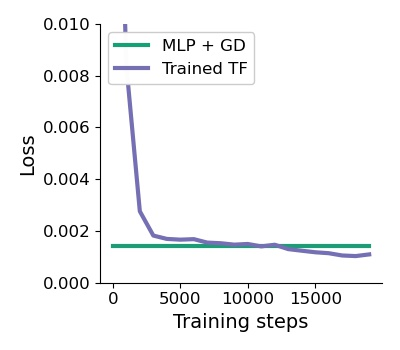

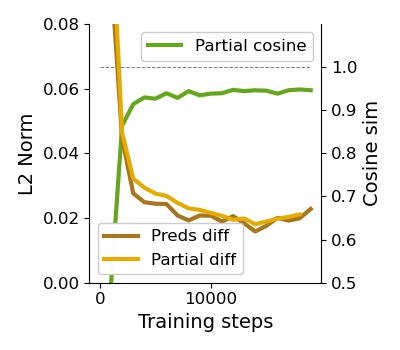

In [8]:
#@title Visualize loss and alignment

display_learning(loss_trans_list, test=losses_gd_list, y_lim_u=0.01, y_lim_l=0.0,
                 rw=1, title="train.pdf", allow_download=False, title3='GD', 
                 title1='Trained TF', title2='MLP + GD', single_seeds=True,
                 num_iter_os=len(loss_trans_list[0])*1000)

display_learning(cos_sim_list, grad_norm_list, p_norm_list, title1="Partial cosine",
                 title2="Partial diff", y_lim_u=0.08, 
                 title3="Preds diff", second_axis=True, 
                 y_lim_u2=1.09999,  color_add=0.2, loc_sec = 'lower left',
                 y_lim_l2=0.5,
                 rw=1, num_iter_os=len(cos_sim_list[0])*1000, title="sim.pdf",
                 allow_download=False)

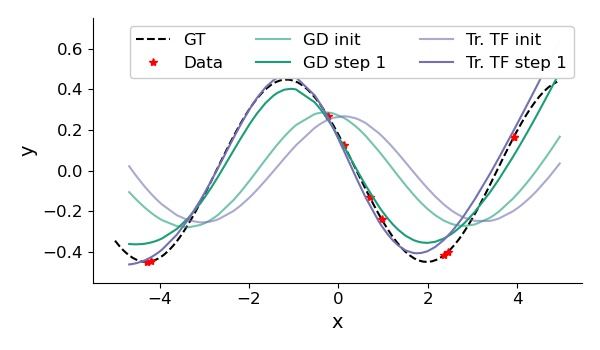

In [9]:
#@title Visualize functions before and after GD / SA layer

rng, eval_rng = jax.random.split(eval_rng, 2)

preds, eval_data = test_sin(params_c, rng, True)
preds_tr, eval_data = test_sin(save_train_params, rng, False)
sin_plot(preds, eval_data, other_preds=preds_tr, y_lim_l=-0.55, y_lim_u=0.75)